In [ ]:
!pip install torchio
%pip install --quiet torchvision
%pip install --quiet matplotlib
#!pip install numpy<1.24
!apt -qq install tree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.8/172.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 13.3.4
    Uninstalling rich-13.3.4:
      Successfully uninstalled rich-13.3.4
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Selecting previously unselected package tree.
(Reading database ... 122518 files and directories currently installed.)
Preparing to unpack .../tree_1.8.0-1_amd64.deb ...
Unpacking tree (1.8.0-1) ...
Setting up tre

In [ ]:
import os
import enum
import tqdm
import numpy as np
import matplotlib
import sklearn
import time
import copy
import torch.nn.functional as F
import torch
import torchio as tio
from torch.utils.data import DataLoader
import multiprocessing
import torch.backends.cudnn as cudnn
from torch.utils.data import ConcatDataset
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier



num_workers = multiprocessing.cpu_count()

In [ ]:
print(torch.__version__)
print(tio.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(sklearn.__version__)

2.0.0+cu118
0.18.91
1.22.4
3.7.1
1.2.2


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

Sun May  7 21:03:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /gdrive

Mounted at /content/drive
[Errno 2] No such file or directory: '/gdrive'
/content


In [ ]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/IMA205/ima205-challenge-2023")

In [ ]:
data_path = "/content/drive/MyDrive/IMA205/ima205-challenge-2023"


for file in sorted(os.listdir(data_path)):
  print(file)

.DS_Store
Classif_model.pt
SampleSubmission.csv
Segmentation_model_.pt
Test
Train
best_models
metaDataTest.csv
metaDataTrain.csv
new_segmentation_models
results
segmentation_model_ED.pt
segmentation_model_ES.pt


In [ ]:
import pandas as pd
df_meta_train = pd.read_csv(os.path.join(data_path, 'metaDataTrain.csv'))
df_meta_test = pd.read_csv(os.path.join(data_path, 'metaDataTest.csv'))

In [ ]:
training_transform = tio.Compose([
    #tio.ToCanonical(),
    tio.Resample((1.3, 1.3, 10)),
    #tio.RandomMotion(p=0.2),
    tio.CropOrPad((300, 300, 10)),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    #tio.OneHot(),
])

training_transform_rot = tio.Compose([
    #tio.ToCanonical(),
    tio.Resample((1.3, 1.3, 10)),
    #tio.RandomMotion(p=0.2),
    tio.CropOrPad((300, 300, 10)),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomAffine(degrees=(90, 90)),
    #tio.OneHot(),
])

validation_transform = tio.Compose([
    #tio.ToCanonical(),
    tio.Resample((1.3, 1.3, 10)),
    tio.CropOrPad((300, 300, 10)),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    #tio.OneHot(),
])


In [ ]:
# create a dataset of first type of mri and the second one
def counter(a):
  if a >= 100:
    return str(a)
  elif a < 10:
    return '00'+str(a)
  else:
    return '0'+str(a)


subjects_ED = []
subjects_ES = []
for i in range(101,151):
  current_dir = os.path.join(data_path, 'Test', counter(i))
  subject_ED = tio.Subject(
        mri=tio.ScalarImage(os.path.join(current_dir, counter(i)+'_ED.nii')),
        segment=tio.LabelMap(os.path.join(current_dir, counter(i)+'_ED_seg.nii')),
        height=df_meta_test.iloc[i-100-1]['Height'],
        weight=df_meta_test.iloc[i-100-1]['Weight'],
    )
  subject_ES = tio.Subject(
        mri=tio.ScalarImage(os.path.join(current_dir, counter(i)+'_ES.nii')),
        segment=tio.LabelMap(os.path.join(current_dir, counter(i)+'_ES_seg.nii')),
        height=df_meta_test.iloc[i-100-1]['Height'],
        weight=df_meta_test.iloc[i-100-1]['Weight'],
    )

  subjects_ED.append(subject_ED)
  subjects_ES.append(subject_ES)


#dataset_ED_test = tio.SubjectsDataset(subjects_ED)
#dataset_ES_test = tio.SubjectsDataset(subjects_ES)


dataset_ED_test = tio.SubjectsDataset(subjects_ED, transform=validation_transform)
dataset_ES_test = tio.SubjectsDataset(subjects_ES, transform=validation_transform)


print('Dataset size:', len(dataset_ED_test), 'subjects')

Dataset size: 50 subjects


In [ ]:
# create a dataset of first type of mri and the second one

subjects_ED = []
subjects_ES = []
subjects_ED_rot = []
subjects_ES_rot = []

permute = np.random.permutation(100)+1


for i in permute:
  current_dir = os.path.join(data_path, 'Train', counter(i))
  subject_ED = tio.Subject(
        mri=tio.ScalarImage(os.path.join(current_dir, counter(i)+'_ED.nii')),
        segment=tio.LabelMap(os.path.join(current_dir, counter(i)+'_ED_seg.nii')),
        height=df_meta_train.iloc[i-1]['Height'],
        weight=df_meta_train.iloc[i-1]['Weight'],
        category=df_meta_train.iloc[i-1]['Category']

    )

  subject_ES = tio.Subject(
        mri=tio.ScalarImage(os.path.join(current_dir, counter(i)+'_ES.nii')),
        segment=tio.LabelMap(os.path.join(current_dir, counter(i)+'_ES_seg.nii')),
        height=df_meta_train.iloc[i-1]['Height'],
        weight=df_meta_train.iloc[i-1]['Weight'],
        category=df_meta_train.iloc[i-1]['Category']
    )



  subjects_ED.append(subject_ED)
  subjects_ES.append(subject_ES)



#dataset_ED_train = tio.SubjectsDataset(subjects_ED)

#dataset_ES_train = tio.SubjectsDataset(subjects_ES)



dataset_ED_train = tio.SubjectsDataset(subjects_ED, transform=training_transform)
#dataset_ED_train_rot_ = tio.SubjectsDataset(subjects_ED, transform=training_transform_rot)
#dataset_ED_train = ConcatDataset([dataset_ED_train_, dataset_ED_train_rot_])



dataset_ES_train = tio.SubjectsDataset(subjects_ES, transform=training_transform)
#dataset_ES_train_rot_ = tio.SubjectsDataset(subjects_ES, transform=training_transform_rot)
#dataset_ES_train = ConcatDataset([dataset_ES_train_, dataset_ES_train_rot_])

'''
lengths = [int(len(dataset_ED_train)*0.8), int(len(dataset_ED_train)*0.2)]
train_ED, valid_ED = torch.utils.data.random_split(dataset_ED_train, lengths)
lengths = [int(len(dataset_ES_train)*0.8), int(len(dataset_ES_train)*0.2)]
train_ES, valid_ES = torch.utils.data.random_split(dataset_ES_train, lengths)
'''
print('Dataset size:', len(dataset_ED_train), 'subjects')

Dataset size: 100 subjects


In [ ]:
'''
training_batch_size = 3
validation_batch_size = 2 * training_batch_size
'''

training_batch_size = 1
validation_batch_size = 1



training_loader_ED = torch.utils.data.DataLoader(
    dataset_ED_train,
    batch_size=training_batch_size,
    shuffle=False,
    num_workers=num_workers,
)
training_loader_ES = torch.utils.data.DataLoader(
    dataset_ES_train,
    batch_size=training_batch_size,
    shuffle=False,
    num_workers=num_workers,
)


test_ED_loader = torch.utils.data.DataLoader(
    dataset_ED_test,
    batch_size=validation_batch_size,
    num_workers=num_workers)

test_ES_loader = torch.utils.data.DataLoader(
    dataset_ES_test,
    batch_size=validation_batch_size,
    num_workers=num_workers)


# calcutaing approximate thickness, circumeference, and circularity

In [ ]:
import math

def circularity(perimeter, area):
  radius = perimeter / (2 * math.pi)
  circular_area = math.pi * radius ** 2
  return circular_area / area

In [ ]:
# extracting some features from the train set
num_points = 30
angles = np.linspace(0, 2*np.pi, num_points)

ED_max_thickness_MYO = []
ED_min_thickness_MYO = []
ED_std_thickness_MYO = []
ED_mean_thickness_MYO = []
ED_circular_MYO = []
ED_circumference_MYO = []

ES_max_thickness_MYO = []
ES_min_thickness_MYO = []
ES_std_thickness_MYO = []
ES_mean_thickness_MYO = []
ES_circular_MYO = []
ES_circumference_MYO = []



for i, (input_1, input_2) in enumerate(zip(training_loader_ED, training_loader_ES)):

  MYO_ED = (input_1['segment'][tio.DATA]==2).int()[0][0].cpu().numpy()
  MYO_ES = (input_2['segment'][tio.DATA]==2).int()[0][0].cpu().numpy()

  LV_ED = (input_1['segment'][tio.DATA]==3).int()[0][0].cpu().numpy()
  LV_ES = (input_2['segment'][tio.DATA]==3).int()[0][0].cpu().numpy()


  for j in range(MYO_ED.shape[2]):
    current_layer_ED = MYO_ED[:,:,j]
    current_layer_ES = MYO_ES[:,:,j]

    current_layer_LV_ED = LV_ED[:,:,j]
    current_layer_LV_ES = LV_ES[:,:,j]

    # for each layer we compute the area that will later be used in calculating the circularity
    area_ED = np.sum(current_layer_ED)+np.sum(current_layer_LV_ED)
    area_ES = np.sum(current_layer_ES)+np.sum(current_layer_LV_ES)

    # this will mater be divided by the mean thickness of the Myo, to caluclate an approximation of the perimeter
    thick_perim_ED = np.sum(current_layer_ED)
    thick_perim_ES = np.sum(current_layer_ES)

    ring_indices_ED = np.argwhere(current_layer_ED)
    ring_indices_ES = np.argwhere(current_layer_ES)

    if len(ring_indices_ED)>0:

      center_ED = np.mean(ring_indices_ED, axis=0)
      distances_ED = np.linalg.norm(ring_indices_ED - center_ED, axis=1)
      min_radius = np.min(distances_ED)
      # print(min_radius)

      current_cut_thicknesses = []

      for angle in angles:
        unit_vector = np.array([np.cos(angle), np.sin(angle)])
        point_on_ring = center_ED + min_radius * unit_vector
        point_on_ring_int = point_on_ring.astype(np.int64)
        augmenter = 0
        while point_on_ring_int[0] >=0 and point_on_ring_int[1]>=0 and point_on_ring_int[0] < current_layer_ED.shape[0] and point_on_ring_int[1] < current_layer_ED.shape[1] and  current_layer_ED[point_on_ring_int[0],point_on_ring_int[1]]==0:
          augmenter += 0.05
          point_on_ring = center_ED + (min_radius+augmenter) * unit_vector
          point_on_ring_int = point_on_ring.astype(np.int64)

        start_ring_current_dir = np.linalg.norm(point_on_ring_int - center_ED)


        point_on_ring = center_ED + (min_radius+augmenter) * unit_vector
        point_on_ring_int = point_on_ring.astype(np.int64)
        while point_on_ring_int[0] >=0 and point_on_ring_int[1]>=0 and point_on_ring_int[0] < current_layer_ED.shape[0] and point_on_ring_int[1] < current_layer_ED.shape[1] and  current_layer_ED[point_on_ring_int[0],point_on_ring_int[1]]==1:
          augmenter += 0.05
          point_on_ring = center_ED + (min_radius+augmenter) * unit_vector
          point_on_ring_int = point_on_ring.astype(np.int64)

        end_ring_current_dir = np.linalg.norm(point_on_ring_int - center_ED)

        # print(start_ring_current_dir, '  ', end_ring_current_dir)


        thickness_current_angle = end_ring_current_dir - start_ring_current_dir
        current_cut_thicknesses.append(thickness_current_angle)

    else:
      current_cut_thicknesses = np.zeros_like(angles)


    # for the current layer j
    mean_thickness_layer = np.mean(current_cut_thicknesses)
    # this is of shape 10. We can use this to calculate circularity for each layer =>
    # take all of those == 2 in each layer, divide by mean thickness, and this gives an approximation of the perimeter
    # then we neeed to calculate the area of the shape => sum of ==3 and ==2 for each layer.
    # we can then use the circularity function defined above to calculate the cirularity.
    if mean_thickness_layer!=0:
      approx_perim_ED = thick_perim_ED/mean_thickness_layer
      circular_ED = circularity(approx_perim_ED, area_ED)
    else:
      approx_perim_ED = -1
      circular_ED = -1

    std_thickness_layer = np.std(current_cut_thicknesses)
    min_thickness_layer = np.min(current_cut_thicknesses)
    max_thickness_layer = np.max(current_cut_thicknesses)


    # adding it up for the current layer, and there are 10 layers for each image
    ED_max_thickness_MYO.append(max_thickness_layer)
    ED_min_thickness_MYO .append(min_thickness_layer)
    ED_std_thickness_MYO.append(std_thickness_layer)
    ED_mean_thickness_MYO.append(mean_thickness_layer)
    ED_circular_MYO.append(circular_ED)
    ED_circumference_MYO.append(approx_perim_ED)




    if len(ring_indices_ES)>0:

      center_ES = np.mean(ring_indices_ES, axis=0)
      distances_ES = np.linalg.norm(ring_indices_ES - center_ES, axis=1)
      min_radius = np.min(distances_ES)
      # print(min_radius)

      current_cut_thicknesses = []

      for angle in angles:
        unit_vector = np.array([np.cos(angle), np.sin(angle)])
        point_on_ring = center_ES + min_radius * unit_vector
        point_on_ring_int = point_on_ring.astype(np.int64)
        augmenter = 0
        while point_on_ring_int[0] >=0 and point_on_ring_int[1]>=0 and point_on_ring_int[0] < current_layer_ES.shape[0] and point_on_ring_int[1] < current_layer_ES.shape[1] and  current_layer_ES[point_on_ring_int[0],point_on_ring_int[1]]==0:
          augmenter += 0.05
          point_on_ring = center_ES + (min_radius+augmenter) * unit_vector
          point_on_ring_int = point_on_ring.astype(np.int64)

        start_ring_current_dir = np.linalg.norm(point_on_ring_int - center_ES)


        point_on_ring = center_ES + (min_radius+augmenter) * unit_vector
        point_on_ring_int = point_on_ring.astype(np.int64)
        while point_on_ring_int[0] >=0 and point_on_ring_int[1]>=0 and point_on_ring_int[0] < current_layer_ES.shape[0] and point_on_ring_int[1] < current_layer_ES.shape[1] and  current_layer_ES[point_on_ring_int[0],point_on_ring_int[1]]==1:
          augmenter += 0.05
          point_on_ring = center_ES + (min_radius+augmenter) * unit_vector
          point_on_ring_int = point_on_ring.astype(np.int64)

        end_ring_current_dir = np.linalg.norm(point_on_ring_int - center_ES)

        # print(start_ring_current_dir, '  ', end_ring_current_dir)


        thickness_current_angle = end_ring_current_dir - start_ring_current_dir
        current_cut_thicknesses.append(thickness_current_angle)

    else:
      current_cut_thicknesses = np.zeros_like(angles)


    # for the current layer j
    mean_thickness_layer = np.mean(current_cut_thicknesses)
    if mean_thickness_layer!=0:
      approx_perim_ES = thick_perim_ES/mean_thickness_layer
      circular_ES = circularity(approx_perim_ES, area_ES)
    else:
      approx_perim_ES = -1
      circular_ES = -1
    std_thickness_layer = np.std(current_cut_thicknesses)
    min_thickness_layer = np.min(current_cut_thicknesses)
    max_thickness_layer = np.max(current_cut_thicknesses)


    # adding it up for the current layer, and there are 10 layers for each image
    ES_max_thickness_MYO.append(max_thickness_layer)
    ES_min_thickness_MYO .append(min_thickness_layer)
    ES_std_thickness_MYO.append(std_thickness_layer)
    ES_mean_thickness_MYO.append(mean_thickness_layer)
    ES_circular_MYO.append(circular_ES)
    ES_circumference_MYO.append(approx_perim_ES)




In [ ]:
train_ED_max_thickness_MYO = np.array(ED_max_thickness_MYO).reshape(-1,10)
train_ED_min_thickness_MYO = np.array(ED_min_thickness_MYO).reshape(-1,10)
train_ED_std_thickness_MYO = np.array(ED_std_thickness_MYO).reshape(-1,10)
train_ED_mean_thickness_MYO = np.array(ED_mean_thickness_MYO).reshape(-1,10)
train_ED_circular_MYO = np.array(ED_circular_MYO).reshape(-1,10)
train_ED_circumference_MYO = np.array(ED_circumference_MYO).reshape(-1,10)

train_ES_max_thickness_MYO = np.array(ES_max_thickness_MYO).reshape(-1,10)
train_ES_min_thickness_MYO = np.array(ES_min_thickness_MYO).reshape(-1,10)
train_ES_std_thickness_MYO = np.array(ES_std_thickness_MYO).reshape(-1,10)
train_ES_mean_thickness_MYO = np.array(ES_mean_thickness_MYO).reshape(-1,10)
train_ES_circular_MYO = np.array(ES_circular_MYO).reshape(-1,10)
train_ES_circumference_MYO = np.array(ES_circumference_MYO).reshape(-1,10)

In [ ]:
# doing the calculation for the train set
# we have the volumes already


volume_ED_LV = []
volume_ED_RV = []
volume_ED_MYO = []

volume_ES_LV = []
volume_ES_RV = []
volume_ES_MYO = []

Vol_Change_LV = []
Vol_Change_RV = []
Vol_Change_MYO = []


LV_ejection = []
RV_ejection = []

rat_RV_LV_ED = []
rat_RV_LV_ES = []

rat_MYO_LV_ED = []
rat_MYO_LV_ES = []

height = []
weight = []


target = []

for i, (input_1, input_2) in enumerate(zip(training_loader_ED, training_loader_ES)):
  LV_ED = torch.sum((input_1['segment'][tio.DATA]==3).int(), (1,2,3,4)).float()
  RV_ED = torch.sum((input_1['segment'][tio.DATA]==1).int(), (1,2,3,4)).float()
  MYO_ED = torch.sum((input_1['segment'][tio.DATA]==2).int(), (1,2,3,4)).float()

  vol_total = LV_ED+RV_ED+MYO_ED
  LV_ED = LV_ED/vol_total
  RV_ED = RV_ED/vol_total
  MYO_ED = MYO_ED/vol_total

  volume_ED_LV.append(LV_ED)
  volume_ED_RV.append(RV_ED)
  volume_ED_MYO.append(MYO_ED)


  rat_RV_LV_ED.append(RV_ED/LV_ED)
  rat_MYO_LV_ED.append(MYO_ED/LV_ED)


  LV_ES = torch.sum((input_2['segment'][tio.DATA]==3).int(), (1,2,3,4)).float()
  RV_ES = torch.sum((input_2['segment'][tio.DATA]==1).int(), (1,2,3,4)).float()
  MYO_ES = torch.sum((input_2['segment'][tio.DATA]==2).int(), (1,2,3,4)).float()
  vol_total = LV_ES+RV_ES+MYO_ES
  LV_ES = LV_ES/vol_total
  RV_ES = RV_ES/vol_total
  MYO_ES = MYO_ES/vol_total

  volume_ES_LV.append(LV_ES)
  volume_ES_RV.append(RV_ES)
  volume_ES_MYO.append(MYO_ES)

  rat_RV_LV_ES.append(RV_ES/LV_ES)
  rat_MYO_LV_ES.append(MYO_ES/LV_ES)


  LV_ejection.append((LV_ES-LV_ED)/LV_ED)
  RV_ejection.append((RV_ES-RV_ED)/RV_ED)

  Vol_Change_LV.append((LV_ES-LV_ED))
  Vol_Change_RV.append((RV_ES-RV_ED))


  height.append(input_1['height'])
  weight.append(input_1['weight'])



  target.append(input_1['category'])


In [ ]:
volume_ED_LV = np.concatenate(volume_ED_LV)[:, None]
volume_ED_RV = np.concatenate(volume_ED_RV)[:, None]
volume_ED_MYO = np.concatenate(volume_ED_MYO)[:, None]

volume_ES_LV = np.concatenate(volume_ES_LV)[:, None]
volume_ES_RV = np.concatenate(volume_ES_RV)[:, None]
volume_ES_MYO = np.concatenate(volume_ES_MYO)[:, None]


LV_ejection = np.concatenate(LV_ejection)[:, None]
RV_ejection = np.concatenate(RV_ejection)[:, None]


Vol_Change_LV = np.concatenate(Vol_Change_LV)[:, None]
Vol_Change_RV = np.concatenate(Vol_Change_RV)[:, None]


rat_RV_LV_ED = np.concatenate(rat_RV_LV_ED)[:, None]
rat_RV_LV_ES = np.concatenate(rat_RV_LV_ES)[:, None]

rat_MYO_LV_ED = np.concatenate(rat_MYO_LV_ED)[:, None]
rat_MYO_LV_ES = np.concatenate(rat_MYO_LV_ES)[:, None]

height = np.concatenate(height)[:, None]
weight = np.concatenate(weight)[:, None]

In [ ]:
X_train = np.concatenate((volume_ED_LV,volume_ED_RV,volume_ED_MYO,
                          volume_ES_LV,volume_ES_RV,volume_ES_MYO,
                          LV_ejection,RV_ejection,
                          Vol_Change_LV,Vol_Change_RV,
                          rat_RV_LV_ED,rat_RV_LV_ES,
                          rat_MYO_LV_ED,rat_MYO_LV_ES,
                          train_ED_mean_thickness_MYO, train_ES_mean_thickness_MYO,
                          train_ED_std_thickness_MYO, train_ES_std_thickness_MYO,
                          train_ED_min_thickness_MYO, train_ES_min_thickness_MYO,
                          train_ED_max_thickness_MYO, train_ES_max_thickness_MYO,
                          train_ED_circular_MYO, train_ES_circular_MYO,
                          train_ED_circumference_MYO, train_ES_circumference_MYO,
                          height,weight), axis=1)
y_train = np.concatenate(target)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(100, 136)
(100,)


# Operations on test dataset

# Finding the left ventricle regions in test dataset, ED

In [ ]:
test_masks_ED = []
for i, input in enumerate(test_ED_loader):

  target = (input['segment'][tio.DATA]).to(device).int().cpu().numpy()
  # first of all, put everything to the class 0 and 2 => let the zero be zero, let the 2 be 2, convert 1 to 0
  target[target==1] = 0


  for j in range(target.shape[0]):
    current_batch_target = target[j,0,:]-1 # so the values will be -1 and 1
    #print(current_batch_target.shape)
    mask_LV = np.zeros_like(current_batch_target)

    for n_slice in range(current_batch_target.shape[2]):
      for x_step in range(current_batch_target.shape[0]):

        y_step = 0
        start_LV = -1
        end_LV = -1
        while y_step < current_batch_target.shape[1] and current_batch_target[x_step,y_step,n_slice]==-1:
          y_step += 1
        while y_step < current_batch_target.shape[1] and current_batch_target[x_step,y_step,n_slice]==1:
          y_step += 1
        start_LV = y_step
        while y_step < current_batch_target.shape[1] and current_batch_target[x_step,y_step,n_slice]==-1:
          y_step += 1
        end_LV = y_step
        if start_LV != current_batch_target.shape[1] and end_LV != current_batch_target.shape[1]:
          for k in range(start_LV, end_LV):
            mask_LV[x_step, k, n_slice] = 1

  test_masks_ED.append(mask_LV)


# Finding the left ventricle regions in test dataset, ES

In [ ]:
test_masks_ES = []
for i, input in enumerate(test_ES_loader):

  target = (input['segment'][tio.DATA]).to(device).int().cpu().numpy()
  # first of all, put everything to the class 0 and 2 => let the zero be zero, let the 2 be 2, convert 1 to 0
  target[target==1] = 0


  for j in range(target.shape[0]):
    current_batch_target = target[j,0,:]-1 # so the values will be -1 and 1
    #print(current_batch_target.shape)
    mask_LV = np.zeros_like(current_batch_target)

    for n_slice in range(current_batch_target.shape[2]):
      for x_step in range(current_batch_target.shape[0]):

        y_step = 0
        start_LV = -1
        end_LV = -1
        while y_step < current_batch_target.shape[1] and current_batch_target[x_step,y_step,n_slice]==-1:
          y_step += 1
        while y_step < current_batch_target.shape[1] and current_batch_target[x_step,y_step,n_slice]==1:
          y_step += 1
        start_LV = y_step
        while y_step < current_batch_target.shape[1] and current_batch_target[x_step,y_step,n_slice]==-1:
          y_step += 1
        end_LV = y_step
        if start_LV != current_batch_target.shape[1] and end_LV != current_batch_target.shape[1]:
          for k in range(start_LV, end_LV):
            mask_LV[x_step, k, n_slice] = 1

  test_masks_ES.append(mask_LV)


# Having a look at some of the segmented images

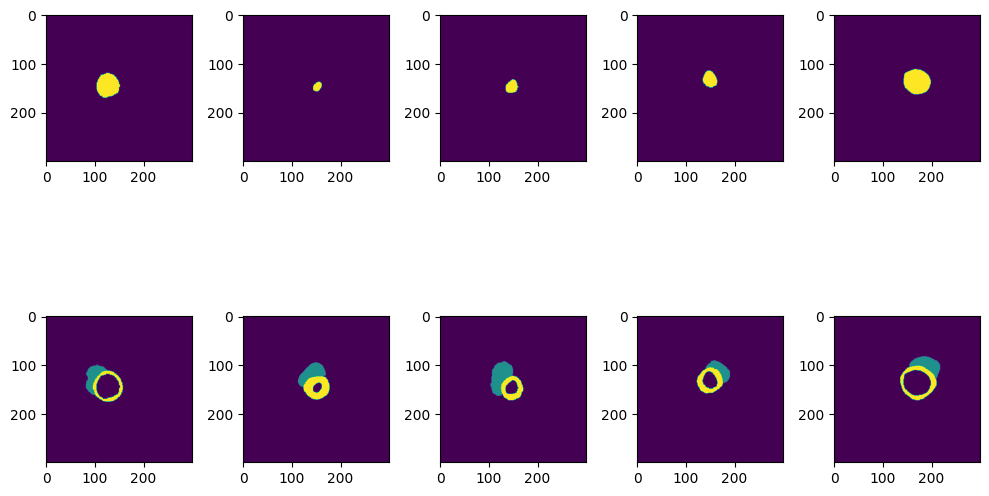

In [ ]:
fig, axs = plt.subplots(2, 5,
                        figsize =(10, 7),
                        tight_layout = True)

for i, input in enumerate(test_ES_loader):

  if i%10==0:
    target = (input['segment'][tio.DATA]).to(device).int().cpu().numpy()
    axs[0,i//10].imshow(test_masks_ES[i][:,:,3])
    axs[1,i//10].imshow(target[0,0,:,:,3])

plt.show()

In [ ]:
# extracting some features from the test set
num_points = 30
angles = np.linspace(0, 2*np.pi, num_points)

ED_max_thickness_MYO = []
ED_min_thickness_MYO = []
ED_std_thickness_MYO = []
ED_mean_thickness_MYO = []
ED_circular_MYO = []
ED_circumference_MYO = []

ES_max_thickness_MYO = []
ES_min_thickness_MYO = []
ES_std_thickness_MYO = []
ES_mean_thickness_MYO = []
ES_circular_MYO = []
ES_circumference_MYO = []


for i, (input_1, input_2) in enumerate(zip(test_ED_loader, test_ES_loader)):

  MYO_ED = (input_1['segment'][tio.DATA]==2).int()[0][0].cpu().numpy()
  MYO_ES = (input_2['segment'][tio.DATA]==2).int()[0][0].cpu().numpy()

  LV_ED = test_masks_ED[i]
  LV_ES = test_masks_ES[i]


  for j in range(MYO_ED.shape[2]):
    current_layer_ED = MYO_ED[:,:,j]
    current_layer_ES = MYO_ES[:,:,j]

    current_layer_LV_ED = LV_ED[:,:,j]
    current_layer_LV_ES = LV_ES[:,:,j]

    # for each layer we compute the area that will later be used in calculating the circularity
    area_ED = np.sum(current_layer_ED)+np.sum(current_layer_LV_ED)
    area_ES = np.sum(current_layer_ES)+np.sum(current_layer_LV_ES)

    # this will mater be divided by the mean thickness of the Myo, to caluclate an approximation of the perimeter
    thick_perim_ED = np.sum(current_layer_ED)
    thick_perim_ES = np.sum(current_layer_ES)

    ring_indices_ED = np.argwhere(current_layer_ED)
    ring_indices_ES = np.argwhere(current_layer_ES)

    if len(ring_indices_ED)>0:

      center_ED = np.mean(ring_indices_ED, axis=0)
      distances_ED = np.linalg.norm(ring_indices_ED - center_ED, axis=1)
      min_radius = np.min(distances_ED)
      # print(min_radius)

      current_cut_thicknesses = []

      for angle in angles:
        unit_vector = np.array([np.cos(angle), np.sin(angle)])
        point_on_ring = center_ED + min_radius * unit_vector
        point_on_ring_int = point_on_ring.astype(np.int64)
        augmenter = 0
        while point_on_ring_int[0] >=0 and point_on_ring_int[1]>=0 and point_on_ring_int[0] < current_layer_ED.shape[0] and point_on_ring_int[1] < current_layer_ED.shape[1] and current_layer_ED[point_on_ring_int[0],point_on_ring_int[1]]==0:
          augmenter += 0.05
          point_on_ring = center_ED + (min_radius+augmenter) * unit_vector
          point_on_ring_int = point_on_ring.astype(np.int64)

        start_ring_current_dir = np.linalg.norm(point_on_ring_int - center_ED)


        point_on_ring = center_ED + (min_radius+augmenter) * unit_vector
        point_on_ring_int = point_on_ring.astype(np.int64)
        while  point_on_ring_int[0] >=0 and point_on_ring_int[1]>=0 and point_on_ring_int[0] < current_layer_ED.shape[0] and point_on_ring_int[1] < current_layer_ED.shape[1] and current_layer_ED[point_on_ring_int[0],point_on_ring_int[1]]==1:
          augmenter += 0.05
          point_on_ring = center_ED + (min_radius+augmenter) * unit_vector
          point_on_ring_int = point_on_ring.astype(np.int64)

        end_ring_current_dir = np.linalg.norm(point_on_ring_int - center_ED)

        # print(start_ring_current_dir, '  ', end_ring_current_dir)


        thickness_current_angle = end_ring_current_dir - start_ring_current_dir
        current_cut_thicknesses.append(thickness_current_angle)

    else:
      current_cut_thicknesses = np.zeros_like(angles)


    # for the current layer j
    mean_thickness_layer = np.mean(current_cut_thicknesses)
    if mean_thickness_layer!=0:
      approx_perim_ED = thick_perim_ED/mean_thickness_layer
      circular_ED = circularity(approx_perim_ED, area_ED)
    else:
      approx_perim_ED = -1
      circular_ED = -1
    std_thickness_layer = np.std(current_cut_thicknesses)
    min_thickness_layer = np.min(current_cut_thicknesses)
    max_thickness_layer = np.max(current_cut_thicknesses)


    # adding it up for the current layer, and there are 10 layers for each image
    ED_max_thickness_MYO.append(max_thickness_layer)
    ED_min_thickness_MYO .append(min_thickness_layer)
    ED_std_thickness_MYO.append(std_thickness_layer)
    ED_mean_thickness_MYO.append(mean_thickness_layer)
    ED_circular_MYO.append(circular_ED)
    ED_circumference_MYO.append(approx_perim_ED)


    if len(ring_indices_ES)>0:

      center_ES = np.mean(ring_indices_ES, axis=0)
      distances_ES = np.linalg.norm(ring_indices_ES - center_ES, axis=1)
      min_radius = np.min(distances_ES)
      # print(min_radius)

      current_cut_thicknesses = []

      for angle in angles:
        unit_vector = np.array([np.cos(angle), np.sin(angle)])
        point_on_ring = center_ES + min_radius * unit_vector
        point_on_ring_int = point_on_ring.astype(np.int64)
        augmenter = 0
        while  point_on_ring_int[0] >=0 and point_on_ring_int[1]>=0 and point_on_ring_int[0] < current_layer_ED.shape[0] and point_on_ring_int[1] < current_layer_ED.shape[1] and current_layer_ES[point_on_ring_int[0],point_on_ring_int[1]]==0:
          augmenter += 0.05
          point_on_ring = center_ES + (min_radius+augmenter) * unit_vector
          point_on_ring_int = point_on_ring.astype(np.int64)

        start_ring_current_dir = np.linalg.norm(point_on_ring_int - center_ES)


        point_on_ring = center_ES + (min_radius+augmenter) * unit_vector
        point_on_ring_int = point_on_ring.astype(np.int64)
        while point_on_ring_int[0] >=0 and point_on_ring_int[1]>=0 and point_on_ring_int[0] < current_layer_ED.shape[0] and point_on_ring_int[1] < current_layer_ED.shape[1] and current_layer_ES[point_on_ring_int[0],point_on_ring_int[1]]==1:
          augmenter += 0.05
          point_on_ring = center_ES + (min_radius+augmenter) * unit_vector
          point_on_ring_int = point_on_ring.astype(np.int64)

        end_ring_current_dir = np.linalg.norm(point_on_ring_int - center_ES)

        # print(start_ring_current_dir, '  ', end_ring_current_dir)


        thickness_current_angle = end_ring_current_dir - start_ring_current_dir
        current_cut_thicknesses.append(thickness_current_angle)

    else:
      current_cut_thicknesses = np.zeros_like(angles)


    # for the current layer j
    mean_thickness_layer = np.mean(current_cut_thicknesses)
    if mean_thickness_layer!=0:
      approx_perim_ES = thick_perim_ES/mean_thickness_layer
      circular_ES = circularity(approx_perim_ES, area_ES)
    else:
      approx_perim_ES = -1
      circular_ES = -1
    std_thickness_layer = np.std(current_cut_thicknesses)
    min_thickness_layer = np.min(current_cut_thicknesses)
    max_thickness_layer = np.max(current_cut_thicknesses)


    # adding it up for the current layer, and there are 10 layers for each image
    ES_max_thickness_MYO.append(max_thickness_layer)
    ES_min_thickness_MYO .append(min_thickness_layer)
    ES_std_thickness_MYO.append(std_thickness_layer)
    ES_mean_thickness_MYO.append(mean_thickness_layer)
    ES_circular_MYO.append(circular_ES)
    ES_circumference_MYO.append(approx_perim_ES)


In [ ]:
test_ED_max_thickness_MYO = np.array(ED_max_thickness_MYO).reshape(-1,10)
test_ED_min_thickness_MYO = np.array(ED_min_thickness_MYO).reshape(-1,10)
test_ED_std_thickness_MYO = np.array(ED_std_thickness_MYO).reshape(-1,10)
test_ED_mean_thickness_MYO = np.array(ED_mean_thickness_MYO).reshape(-1,10)
test_ED_circular_MYO = np.array(ED_circular_MYO).reshape(-1,10)
test_ED_circumference_MYO = np.array(ED_circumference_MYO).reshape(-1,10)

test_ES_max_thickness_MYO = np.array(ES_max_thickness_MYO).reshape(-1,10)
test_ES_min_thickness_MYO = np.array(ES_min_thickness_MYO).reshape(-1,10)
test_ES_std_thickness_MYO = np.array(ES_std_thickness_MYO).reshape(-1,10)
test_ES_mean_thickness_MYO = np.array(ES_mean_thickness_MYO).reshape(-1,10)
test_ES_circular_MYO = np.array(ES_circular_MYO).reshape(-1,10)
test_ES_circumference_MYO = np.array(ES_circumference_MYO).reshape(-1,10)

In [ ]:
volume_ED_LV_test = []
volume_ED_RV_test = []
volume_ED_MYO_test = []



volume_ES_LV_test = []
volume_ES_RV_test = []
volume_ES_MYO_test = []


LV_ejection_test = []
RV_ejection_test = []

Vol_Change_LV_test = []
Vol_Change_RV_test = []
Vol_Change_MYO_test = []

rat_RV_LV_ED_test = []
rat_RV_LV_ES_test = []

rat_MYO_LV_ED_test = []
rat_MYO_LV_ES_test = []

height_test = []
weight_test = []



for i, (input_1, input_2) in enumerate(zip(test_ED_loader, test_ES_loader)):
  # LV_ED = torch.sum((input_1['segment'][tio.DATA]==3).int(), (1,2,3,4)).float()
  LV_ED = np.sum(test_masks_ED[i])
  RV_ED = torch.sum((input_1['segment'][tio.DATA]==1).int(), (1,2,3,4)).float()
  MYO_ED = torch.sum((input_1['segment'][tio.DATA]==2).int(), (1,2,3,4)).float()

  vol_total = LV_ED+RV_ED+MYO_ED
  LV_ED = LV_ED/vol_total
  RV_ED = RV_ED/vol_total
  MYO_ED = MYO_ED/vol_total

  volume_ED_LV_test.append(LV_ED)
  volume_ED_RV_test.append(RV_ED)
  volume_ED_MYO_test.append(MYO_ED)

  rat_RV_LV_ED_test.append(RV_ED/LV_ED)
  rat_MYO_LV_ED_test.append(MYO_ED/LV_ED)



  LV_ES = np.sum(test_masks_ES[i])
  RV_ES = torch.sum((input_2['segment'][tio.DATA]==1).int(), (1,2,3,4)).float()
  MYO_ES = torch.sum((input_2['segment'][tio.DATA]==2).int(), (1,2,3,4)).float()
  vol_total = LV_ES+RV_ES+MYO_ES
  LV_ES = LV_ES/vol_total
  RV_ES = RV_ES/vol_total
  MYO_ES = MYO_ES/vol_total

  volume_ES_LV_test.append(LV_ES)
  volume_ES_RV_test.append(RV_ES)
  volume_ES_MYO_test.append(MYO_ES)

  rat_RV_LV_ES_test.append(RV_ES/LV_ES)
  rat_MYO_LV_ES_test.append(MYO_ES/LV_ES)


  LV_ejection_test.append((LV_ES-LV_ED)/LV_ED)
  RV_ejection_test.append((RV_ES-RV_ED)/RV_ED)

  Vol_Change_LV_test.append((LV_ES-LV_ED))
  Vol_Change_RV_test.append((RV_ES-RV_ED))


  height_test.append(input_1['height'])
  weight_test.append(input_1['weight'])

In [ ]:
volume_ED_LV_test = np.concatenate(volume_ED_LV_test)[:, None]
volume_ED_RV_test = np.concatenate(volume_ED_RV_test)[:, None]
volume_ED_MYO_test = np.concatenate(volume_ED_MYO_test)[:, None]

volume_ES_LV_test = np.concatenate(volume_ES_LV_test)[:, None]
volume_ES_RV_test = np.concatenate(volume_ES_RV_test)[:, None]
volume_ES_MYO_test = np.concatenate(volume_ES_MYO_test)[:, None]


LV_ejection_test = np.concatenate(LV_ejection_test)[:, None]
RV_ejection_test = np.concatenate(RV_ejection_test)[:, None]


Vol_Change_LV_test = np.concatenate(Vol_Change_LV_test)[:, None]
Vol_Change_RV_test = np.concatenate(Vol_Change_RV_test)[:, None]

rat_RV_LV_ED_test = np.concatenate(rat_RV_LV_ED_test)[:, None]
rat_RV_LV_ES_test = np.concatenate(rat_RV_LV_ES_test)[:, None]

rat_MYO_LV_ED_test = np.concatenate(rat_MYO_LV_ED_test)[:, None]
rat_MYO_LV_ES_test = np.concatenate(rat_MYO_LV_ES_test)[:, None]

height_test = np.concatenate(height_test)[:, None]
weight_test = np.concatenate(weight_test)[:, None]

In [ ]:
X_test = np.concatenate((volume_ED_LV_test,volume_ED_RV_test,
                         volume_ED_MYO_test,volume_ES_LV_test,
                         volume_ES_RV_test,volume_ES_MYO_test,
                         LV_ejection_test,RV_ejection_test,
                         Vol_Change_LV_test, Vol_Change_RV_test,
                         rat_RV_LV_ED_test,rat_RV_LV_ES_test,
                         rat_MYO_LV_ED_test,rat_MYO_LV_ES_test,
                         test_ED_mean_thickness_MYO, test_ES_mean_thickness_MYO,
                         test_ED_std_thickness_MYO, test_ES_std_thickness_MYO,
                         test_ED_min_thickness_MYO, test_ES_min_thickness_MYO,
                         test_ED_max_thickness_MYO, test_ES_max_thickness_MYO,
                         test_ED_circular_MYO, test_ES_circular_MYO,
                         test_ED_circumference_MYO, test_ES_circumference_MYO,
                         height_test,weight_test), axis=1)

# training the models using theses primary obtained features

In [ ]:
RF=RandomForestClassifier(n_estimators=1000)
p_grid_RF = {'random_state': [0,1,2,3,4,5]}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='accuracy', cv=5)
grid_RF.fit(X_train, np.ravel(y_train))


print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_train,np.ravel(y_train)))

Best Validation Score: 0.95
Best params: {'random_state': 0}
Random Forest test score : 1.0


In [ ]:
y_test = grid_RF.predict(X_test)
print(y_test)
data = []
for i in range(101,151):
  data.append([str(i), str(int(y_test[i-101]))])
df = pd.DataFrame(data, columns=['Id', 'Category'])
df.set_index('Id', inplace=True)
df.to_csv(os.path.join(data_path, 'results', 'only_rf.csv'))

[2. 4. 0. 3. 4. 1. 0. 3. 4. 4. 3. 3. 4. 0. 0. 4. 2. 3. 1. 0. 4. 0. 3. 3.
 1. 2. 1. 4. 2. 4. 1. 4. 3. 2. 0. 3. 1. 3. 2. 0. 2. 2. 1. 2. 4. 2. 3. 1.
 1. 1.]


# changing the training method to more complicated ones : ensemble of MLPs

In [ ]:
# creating a dataloader from the extracted features
from torch.utils.data import Dataset

class FeatureDataset(Dataset):
  def __init__(self, features, targets):
    self.features = features
    self.targets = targets

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.targets[index]

In [ ]:
class GaussianNoise(nn.Module):
    def __init__(self, std_dev):
        super(GaussianNoise, self).__init__()
        self.std_dev = std_dev

    def forward(self, x):
        if self.training:
            noise = torch.randn(x.size()) * self.std_dev
            return x + noise
        else:
            return x

In [ ]:
import torch.optim as optim
import torch.nn.functional as F


# Define MLP architecture
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(136, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            GaussianNoise(0.1),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            GaussianNoise(0.1),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            GaussianNoise(0.1),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            GaussianNoise(0.1),
            nn.Linear(32, 5)
        )

    def forward(self, x):
        x = x.view(-1, 136)
        x = self.layers(x)
        return x

# Define training loop
def train(model, input, target, criterion, optimizer, schedular):
    model.train()
    optimizer.zero_grad()
    input = input.to(torch.float32)
    target = target.type(torch.LongTensor)

    outputs = model(input)
    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()
    #schedular.step()

# Define validation loop
def validate(model, val_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(torch.float32)
            labels = labels.type(torch.LongTensor)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            #print(predicted)
            #print(labels)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

# Define validation loop
def test(model, test_loader):
    model.eval()
    labels = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(torch.float32)
            labels.append(F.softmax(model(inputs),dim=1))


    labels = torch.cat([*labels], dim=0)
    return labels



# running the following cell would take a huge amount of time. Instead, the trained models can be accessed from the link in the report (a link to a drive)

In [ ]:
# Set up ensemble
from sklearn.preprocessing import StandardScaler


standard = StandardScaler()
standard.fit(X_train)
X_train_standard=standard.transform(X_train)
X_test_standard=standard.transform(X_test)



ensemble_size = 30
ensemble = [MLP() for _ in range(ensemble_size)]
criterion = nn.CrossEntropyLoss()
optimizers = [optim.Adam(ensemble[i].parameters(), lr=0.0005) for i in range(ensemble_size)]
schedulers = [optim.lr_scheduler.ExponentialLR(optimizers[i], gamma=0.97) for i in range(ensemble_size)]


num_epochs = 400
best_models = []
chosen_indices_feats = []
for model_idx in range(ensemble_size):

  # An epoch is defined as a set of 50 batches containing 20 patients each.
  batch_size = 20
  n_sets_in_epoch = 50
  current_model = ensemble[model_idx]
  current_opt = optimizers[model_idx]
  current_sch = schedulers[model_idx]

  # !choosing only 90 features to train on

  #indices_feats = list(range(X_train.shape[1]))
  #np.random.shuffle(indices_feats)
  #indices_feats = indices_feats[:]
  current_X_train = X_train_standard

  #chosen_indices_feats.append(indices_feats)



  indices = list(range(len(current_X_train)))
  np.random.shuffle(indices)
  train_length = int(len(current_X_train)*0.75)

  train_feats = current_X_train[indices][:train_length]
  train_labels = y_train[indices][:train_length]

  val_feats = current_X_train[indices][train_length:]
  val_labels = y_train[indices][train_length:]

  current_train_dataset = FeatureDataset(train_feats,train_labels)
  current_val_dataset = FeatureDataset(val_feats,val_labels)

  # creating dataloaders from feats
  train_dataloader = DataLoader(current_train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(current_val_dataset, batch_size=batch_size)


  for n_epoch in range(num_epochs):

    for n_set in range(n_sets_in_epoch):

      for input, target in train_dataloader:

        train(current_model, input, target, criterion, current_opt, current_sch)



    # epoch selection
    if n_epoch==0:
      best_acc = validate(current_model, val_dataloader, criterion)
      best_model = copy.copy(current_model)
      best_idx = 0
      print('initial accuracy ', best_acc)
    else:

      current_acc = validate(current_model, val_dataloader, criterion)
      if current_acc >= best_acc:
        best_acc = current_acc
        best_model = copy.copy(current_model)
        best_idx = n_epoch
        print('current best accuracy ', best_acc)

  print('the best epoch for the ', model_idx, ' model is : ', best_idx, ' with an accuracy of ', best_acc)
  best_models.append(best_model)



initial accuracy  0.96
current best accuracy  0.96
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
current best accuracy  1.0
curr

In [ ]:
# writing the trained models down
for i in range(ensemble_size):
  current_path = os.path.join(data_path, 'best_models', 'classifier'+str(i)+'.pt')
  torch.save(best_models[i].state_dict(), current_path)


In [ ]:
# the models are trained with different permutations of features
# (because before I was trying to just pick 90 features out of 136, and this is for compatibility reasons)

data = []

for i in range(ensemble_size):
  data.append(chosen_indices_feats[i])

columns = [str(i) for i in range(136)]
df = pd.DataFrame(data, columns=columns)
df.to_csv(os.path.join(data_path, 'best_models', 'features.txt'))

# the commands to run to retrieve the trained models and combinations of features

In [ ]:
# loading back the saved models
ensemble_size = 30
best_models_regul = []
for i in range(ensemble_size):
  model_save_name = os.path.join(data_path, 'best_models', 'classifier'+str(i)+'.pt')
  current_model = MLP()
  current_model.load_state_dict(torch.load(model_save_name))
  best_models_regul.append(current_model)


In [ ]:
chosen_feats_df = pd.read_csv(os.path.join(data_path, 'best_models', 'features.txt'))
chosen_feats = []
for i in range(ensemble_size):
  chosen_feats.append(np.array(chosen_feats_df.loc[i])[1:])


# Using the models to aggregate scores for different classes
# And evaluate the performance on the whole train set

In [ ]:
batch_size=10

standard = StandardScaler()
standard.fit(X_train)
X_train_standard=standard.transform(X_train)

y_ensemble = torch.zeros((100, 5))
for i in range(ensemble_size):


  #print(np.array(X_train[:,np.array(chosen_feats[i]).reshape(-1)]).shape)
  train_dataset = FeatureDataset(X_train_standard,y_train)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

  y = test(best_models[i], train_dataloader)
  y_ensemble += y


y_ensemble_chosen = torch.argmax(y_ensemble, dim=1)
print(y_ensemble_chosen)
y_ensemble_chosen = y_ensemble_chosen.cpu().numpy()
print((y_ensemble_chosen == y_train).sum().item()/100.)

tensor([4, 3, 4, 4, 2, 4, 1, 0, 1, 1, 2, 0, 1, 1, 0, 2, 2, 0, 2, 1, 3, 4, 2, 1,
        2, 4, 1, 1, 0, 3, 3, 3, 0, 2, 1, 0, 1, 4, 3, 4, 3, 3, 3, 2, 3, 4, 1, 3,
        0, 2, 1, 0, 3, 3, 3, 0, 1, 2, 4, 0, 4, 2, 0, 2, 4, 4, 1, 0, 4, 1, 0, 3,
        0, 2, 2, 3, 2, 1, 1, 3, 0, 4, 0, 2, 0, 4, 4, 3, 1, 2, 4, 3, 2, 3, 0, 4,
        0, 2, 1, 4])
1.0


# Testing the model on the test set

In [ ]:
batch_size=10

X_test_standard=standard.transform(X_test)


y_ensemble = torch.zeros((50, 5))
for i in range(ensemble_size):


  #print(np.array(X_train[:,np.array(chosen_feats[i]).reshape(-1)]).shape)
  test_dataset = FeatureDataset(X_test_standard,np.zeros(X_test.shape[0]))
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

  y = test(best_models[i], test_dataloader)
  y_ensemble += y


y_ensemble_chosen = torch.argmax(y_ensemble, dim=1)
y_ensemble_chosen = y_ensemble_chosen.cpu().numpy()


print(y_ensemble_chosen)



data = []

for i in range(101,151):
  data.append([str(i), str(int(y_ensemble_chosen[i-101]))])
df = pd.DataFrame(data, columns=['Id', 'Category'])
df.set_index('Id', inplace=True)
#print(df)
df.to_csv(os.path.join(data_path, 'results', '26_April_1.csv'))

[2 4 0 3 4 1 0 0 4 0 3 3 0 0 0 4 2 3 1 0 4 0 3 3 1 2 1 4 2 4 1 4 0 2 0 3 2
 3 2 0 2 2 1 2 4 2 0 1 1 1]


# Let us combine the deep models with the random forest

In [ ]:
# This is the golden estimator!! found it!! found it!!
RF1=RandomForestClassifier(random_state=2, n_estimators=1000)
RF2=RandomForestClassifier(random_state=1, n_estimators=1000)
RF3=RandomForestClassifier(random_state=0, n_estimators=1000)

RF1.fit(X_train, np.ravel(y_train))
RF2.fit(X_train, np.ravel(y_train))
RF3.fit(X_train, np.ravel(y_train))

print("Random Forest test score :",RF1.score(X_train,np.ravel(y_train)))
print("Random Forest test score :",RF2.score(X_train,np.ravel(y_train)))
print("Random Forest test score :",RF3.score(X_train,np.ravel(y_train)))

Random Forest test score : 1.0
Random Forest test score : 1.0
Random Forest test score : 1.0


In [ ]:
from sklearn.preprocessing import OneHotEncoder

y_test1 = RF1.predict(X_test)
encoder = OneHotEncoder(categories='auto', sparse=False)
y_test1 = y_test1.reshape(-1, 1)
y_test_one_hot1 = encoder.fit_transform(y_test1)*7

y_test2 = RF2.predict(X_test)
y_test2 = y_test2.reshape(-1, 1)
y_test_one_hot2 = encoder.fit_transform(y_test2)*7


y_test3 = RF3.predict(X_test)
y_test3 = y_test3.reshape(-1, 1)
y_test_one_hot3 = encoder.fit_transform(y_test3)*7


X_test_standard=standard.transform(X_test)


y_ensemble = torch.zeros((50, 5))
for i in range(ensemble_size):


  #print(np.array(X_train[:,np.array(chosen_feats[i]).reshape(-1)]).shape)
  test_dataset = FeatureDataset(X_test_standard,np.zeros(X_test.shape[0]))
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

  y = test(best_models[i], test_dataloader)
  y_ensemble += y


y_ensemble_chosen = torch.argmax(y_ensemble, dim=1)
y_ensemble_chosen = y_ensemble_chosen.cpu().numpy()


print(y_ensemble_chosen)



print(y_ensemble.sum())
y_ensemble += y_test_one_hot1
y_ensemble += y_test_one_hot2
y_ensemble += y_test_one_hot3
print(y_ensemble.sum())
y_ensemble_chosen = torch.argmax(y_ensemble, dim=1)
y_ensemble_chosen = y_ensemble_chosen.cpu().numpy()
print(y_ensemble_chosen)

data = []

for i in range(101,151):
  data.append([str(i), str(int(y_ensemble_chosen[i-101]))])
df = pd.DataFrame(data, columns=['Id', 'Category'])
df.set_index('Id', inplace=True)
print(df)
df.to_csv(os.path.join(data_path, 'results', '26_April_4.csv'))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[2 4 0 3 4 1 0 0 4 0 3 3 0 0 0 4 2 3 1 0 4 0 3 3 1 2 1 4 2 4 1 4 0 2 0 3 2
 3 2 0 2 2 1 2 4 2 0 1 1 1]
tensor(1499.9999)
tensor(2550.0000, dtype=torch.float64)
[2 4 0 3 4 1 0 3 4 4 3 3 4 0 0 4 2 3 1 0 4 0 3 3 1 2 1 4 2 4 1 4 3 2 0 3 2
 3 2 0 2 2 1 2 4 2 0 1 1 1]
    Category
Id          
101        2
102        4
103        0
104        3
105        4
106        1
107        0
108        3
109        4
110        4
111        3
112        3
113        4
114        0
115        0
116        4
117        2
118        3
119        1
120        0
121        4
122        0
123        3
124        3
125        1
126        2
127        1
128        4
129        2
130        4
131        1
132        4
133        3
134        2
135        0
136        3
137        2
138        3
139        2
140        0
141        2
142        2
143        1
144        2
145        4
146        2
147        0
148        1
149        1
150        1


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
